# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [1]:
import pandas as pd
df=pd.read_csv('mammographic_masses.data.txt',na_values=['?'])
df.head()

,5,67,3,5.1,3.1,1
0,4.0,43.0,1.0,1.0,NaN,1
1,5.0,58.0,4.0,5.0,3.0,1
2,4.0,28.0,1.0,1.0,3.0,0
3,5.0,74.0,1.0,5.0,NaN,1
4,4.0,65.0,1.0,NaN,3.0,0


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [2]:
col_names=["BI_RADS", "age", "shape", "margin", "density","severity"]
df.columns=col_names
df.head()

,BI_RADS,age,shape,margin,density,severity
0,4.0,43.0,1.0,1.0,NaN,1
1,5.0,58.0,4.0,5.0,3.0,1
2,4.0,28.0,1.0,1.0,3.0,0
3,5.0,74.0,1.0,5.0,NaN,1
4,4.0,65.0,1.0,NaN,3.0,0


Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [3]:
df.describe()

,BI_RADS,age,shape,margin,density,severity
count,958.000000,955.000000,929.000000,912.000000,884.000000,960.000000
mean,4.347599,55.475393,2.721206,2.793860,2.910633,0.462500
std,1.783838,14.482917,1.243428,1.565702,0.380647,0.498852
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [4]:
import seaborn as sns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [5]:
df.age  = df.age.fillna(value = df.age.mode()[0] )
df.margin  = df.margin.fillna(value = df.margin.mode()[0] )
df.density  = df.density.fillna(value = df.density.mode()[0] )
df.shape  = df['shape'].fillna(value = df['shape'].mode()[0] )

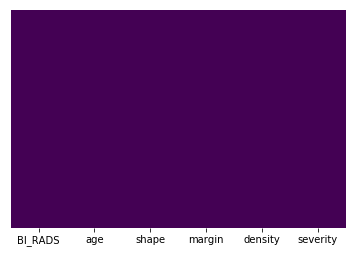

In [6]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [7]:
my_featues = df[['age','shape','margin','density']].values
target =  df['severity'].values
col_names=['age','shape','margin','density']
print(my_featues)
print(target)
print(col_names)

[[43.  1.  1.  3.]
 [58.  4.  5.  3.]
 [28.  1.  1.  3.]
 ...
 [64.  4.  5.  3.]
 [66.  4.  5.  3.]
 [62.  3.  3.  3.]]
[1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1
 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1
 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1
 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1
 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1
 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1
 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0
 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1
 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1
 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0
 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [8]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_features=scaler.fit_transform(my_featues)
scaled_features

array([[-0.86522915, -1.41765235, -1.08233256,  0.22492704],
       [ 0.17356523,  0.99537293,  1.45810573,  0.22492704],
       [-1.90402353, -1.41765235, -1.08233256,  0.22492704],
       ...,
       [ 0.58908298,  0.99537293,  1.45810573,  0.22492704],
       [ 0.7275889 ,  0.99537293,  1.45810573,  0.22492704],
       [ 0.45057706,  0.19103117,  0.18788658,  0.22492704]])

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [9]:
from sklearn.model_selection import train_test_split
X=df[['age', 'shape', 'margin', 'density']]
y= df['severity']
#scaled_features
#target
#X_train, X_test, y_train, y_test = train_test_split(scaled_features,target, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Now create a DecisionTreeClassifier and fit it to your training data.

In [10]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
pred_DT = clf.predict(X_test)

Display the resulting decision tree.

In [110]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=col_names)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

InvocationException: GraphViz's executables not found

Measure the accuracy of the resulting decision tree model using your test data.

In [11]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

print("Individual Accuracy:",clf.score(X_test, y_test))
results3 = confusion_matrix(y_test, pred_DT)
accuracy3=accuracy_score(y_test, pred_DT)
report3=classification_report(y_test, pred_DT) 
print(results3)
print('Decision Tree Accuracy: ',accuracy3)
print('\n')
print(report3)

Individual Accuracy: 0.6958333333333333
[[93 35]
 [38 74]]
Decision Tree Accuracy:  0.6958333333333333


              precision    recall  f1-score   support

           0       0.71      0.73      0.72       128
           1       0.68      0.66      0.67       112

   micro avg       0.70      0.70      0.70       240
   macro avg       0.69      0.69      0.69       240
weighted avg       0.70      0.70      0.70       240



Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf,X,y, cv=10)
print(scores)
print(scores.mean())

[0.69072165 0.78350515 0.78350515 0.72164948 0.6875     0.78125
 0.68421053 0.78947368 0.75789474 0.68421053]
0.736392091698318


Now try a RandomForestClassifier instead. Does it perform better?

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf_rF = RandomForestClassifier(n_estimators=3)
clf_rF = clf.fit(X, y)

pred_RandomFor=clf_rF.predict(X_test)

print("Individual Accuracy:",clf_rF.score(X_test, y_test))
results2 = confusion_matrix(y_test, pred_RandomFor)
accuracy2=accuracy_score(y_test, pred_RandomFor)
report2=classification_report(y_test, pred_RandomFor) 
print(results2)
print('Random Forest Accuracy: ',accuracy2)
print('\n')
print(report2)

Individual Accuracy: 0.8875
[[118  10]
 [ 17  95]]
Random Forest Accuracy:  0.8875


              precision    recall  f1-score   support

           0       0.87      0.92      0.90       128
           1       0.90      0.85      0.88       112

   micro avg       0.89      0.89      0.89       240
   macro avg       0.89      0.89      0.89       240
weighted avg       0.89      0.89      0.89       240



## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [14]:
'''
The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example.
For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job 
of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to 
look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points.
For very tiny values of C, you should get misclassified examples, often even if your training data is linearly separable.
'''
from sklearn.svm import SVC
svc_model = SVC(kernel='linear')
svc_model.fit(X_train,y_train)
svm_predictions = svc_model.predict(X_test)

In [15]:
svm_results = confusion_matrix(y_test, svm_predictions)
svm_accuracy=accuracy_score(y_test, svm_predictions)
svm_report=classification_report(y_test, svm_predictions) 
print(svm_results)
print('SVM Model Accuracy: ',svm_accuracy)
print('\n')
print(svm_report)

[[95 33]
 [18 94]]
SVM Model Accuracy:  0.7875


              precision    recall  f1-score   support

           0       0.84      0.74      0.79       128
           1       0.74      0.84      0.79       112

   micro avg       0.79      0.79      0.79       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.79      0.79      0.79       240



## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)


knn_results = confusion_matrix(y_test, knn_pred)
knn_accuracy=accuracy_score(y_test,knn_pred)
knn_report=classification_report(y_test,knn_pred) 
print(knn_results)
print('KNN Accuracy: ',knn_accuracy)
print('\n')
print(knn_report)

[[97 31]
 [27 85]]
KNN Accuracy:  0.7583333333333333


              precision    recall  f1-score   support

           0       0.78      0.76      0.77       128
           1       0.73      0.76      0.75       112

   micro avg       0.76      0.76      0.76       240
   macro avg       0.76      0.76      0.76       240
weighted avg       0.76      0.76      0.76       240



Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [17]:
import numpy as np
error_rate = []

# Will take some time
for i in range(1,50):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

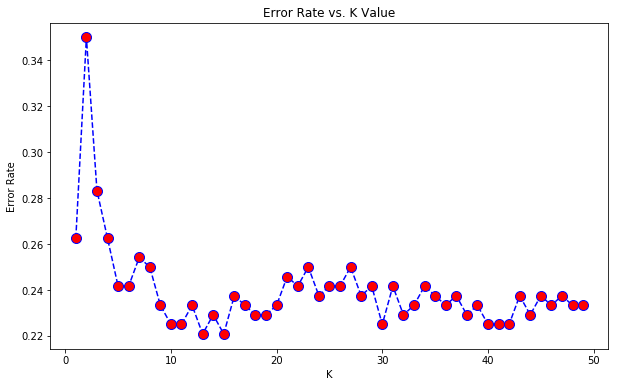

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [19]:
# NOW WITH K=15
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=15')
print('\n')
print(confusion_matrix(y_test,pred))
knn_accuracy=accuracy_score(y_test,knn_pred)
print('KNN Accuracy: ',knn_accuracy)
print('\n')
print(classification_report(y_test,pred))

WITH K=15


[[93 35]
 [18 94]]
KNN Accuracy:  0.7583333333333333


              precision    recall  f1-score   support

           0       0.84      0.73      0.78       128
           1       0.73      0.84      0.78       112

   micro avg       0.78      0.78      0.78       240
   macro avg       0.78      0.78      0.78       240
weighted avg       0.79      0.78      0.78       240



## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [20]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB().fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

nb_results = confusion_matrix(y_test, nb_pred)
nb_accuracy=accuracy_score(y_test, nb_pred)
nb_report=classification_report(y_test,nb_pred) 
print(nb_results)
print('Naive Bayes Model Accuracy: ',nb_accuracy)
print('\n')
print(nb_report)

[[93 35]
 [20 92]]
Naive Bayes Model Accuracy:  0.7708333333333334


              precision    recall  f1-score   support

           0       0.82      0.73      0.77       128
           1       0.72      0.82      0.77       112

   micro avg       0.77      0.77      0.77       240
   macro avg       0.77      0.77      0.77       240
weighted avg       0.78      0.77      0.77       240



## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [21]:
'''
or example linear, nonlinear, polynomial, radial basis function (RBF), and sigmoid.
Introduce Kernel functions for sequence data, graphs, text, images, as well as vectors.
The most used type of kernel function is RBF. Because it has localized and finite response along the entire x-axis.
'''
svc_model = SVC(kernel='rbf')
scores = cross_val_score(svc_model,X,y, cv=10)
print(scores)
print(scores.mean())

C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\

[0.7628866  0.75257732 0.78350515 0.81443299 0.79166667 0.80208333
 0.75789474 0.78947368 0.84210526 0.77894737]
0.7875573114487249


In [22]:
svc_model = SVC(kernel='sigmoid')
scores = cross_val_score(svc_model,X,y, cv=10)
print(scores)
print(scores.mean())

C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\

[0.53608247 0.53608247 0.53608247 0.53608247 0.54166667 0.54166667
 0.53684211 0.53684211 0.53684211 0.53684211]
0.5375031651293182


C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
svc_model = SVC(kernel='poly')
scores = cross_val_score(svc_model,scaled_features,target, cv=10)
print(scores)
print(scores.mean())

C:\Users\Abdul Hannan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [22]:
from sklearn.linear_model import LogisticRegression
lm=LogisticRegression(solver='lbfgs')
model=lm.fit(X_train,y_train)
predict=lm.predict(X_test)

In [23]:
results = confusion_matrix(y_test, predict)
accuracy=accuracy_score(y_test, predict)
report=classification_report(y_test, predict) 
print(results)
print(accuracy)
print('\n')
print(report)

[[98 30]
 [22 90]]
0.7833333333333333


              precision    recall  f1-score   support

           0       0.82      0.77      0.79       128
           1       0.75      0.80      0.78       112

   micro avg       0.78      0.78      0.78       240
   macro avg       0.78      0.78      0.78       240
weighted avg       0.79      0.78      0.78       240



## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [24]:
import tensorflow as tf
model=tf.keras.models.Sequential()


In [25]:
model.add(tf.keras.layers.Dense(6,input_dim=4,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1,activation=tf.nn.sigmoid))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=100,verbose=2)

Train on 720 samples
Epoch 1/100
720/720 - 0s - loss: 7.4995 - accuracy: 0.4611
Epoch 2/100
720/720 - 0s - loss: 7.1703 - accuracy: 0.4611
Epoch 3/100
720/720 - 0s - loss: 6.6555 - accuracy: 0.4611
Epoch 4/100
720/720 - 0s - loss: 5.8657 - accuracy: 0.4611
Epoch 5/100
720/720 - 0s - loss: 4.9508 - accuracy: 0.4611
Epoch 6/100
720/720 - 0s - loss: 4.1277 - accuracy: 0.4611
Epoch 7/100
720/720 - 0s - loss: 3.4295 - accuracy: 0.4611
Epoch 8/100
720/720 - 0s - loss: 2.8293 - accuracy: 0.4611
Epoch 9/100
720/720 - 0s - loss: 2.3211 - accuracy: 0.4611
Epoch 10/100
720/720 - 0s - loss: 1.8778 - accuracy: 0.4611
Epoch 11/100
720/720 - 0s - loss: 1.5008 - accuracy: 0.4611
Epoch 12/100
720/720 - 0s - loss: 1.2053 - accuracy: 0.4653
Epoch 13/100
720/720 - 0s - loss: 0.9833 - accuracy: 0.4903
Epoch 14/100
720/720 - 0s - loss: 0.8440 - accuracy: 0.5125
Epoch 15/100
720/720 - 0s - loss: 0.7663 - accuracy: 0.5194
Epoch 16/100
720/720 - 0s - loss: 0.7263 - accuracy: 0.5333
Epoch 17/100
720/720 - 0s - 

In [26]:
val_loss,val_accuracy=model.evaluate(X_test,y_test)
print('Validation Loss:',val_loss)
print('Validation Accuracy:',val_accuracy)

240/240 [==============================] - 0s 806us/sample - loss: 0.5332 - accuracy: 0.7792
Validation Loss: 0.5332460045814514
Validation Accuracy: 0.77916664


## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!